# PCA-based Face Recognition (Eigenfaces)

This notebook implements a PCA (Eigenfaces) based face recognition system using the AT&T (ORL) dataset. It includes: data download & preprocessing, PCA implemented from scratch, Eigenface visualization, reconstruction experiments, 1-NN classifier in PCA space, accuracy vs number of components, and an optional t-SNE visualization.

Run all cells in order. The notebook will download the dataset into the working directory if it is not already available.

In [1]:
# Imports and helper functions
import os
import urllib.request
import zipfile
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from pathlib import Path
from PIL import Image
import time

plt.rcParams['figure.figsize'] = (10,6)

def show_images(images, titles=None, h=112, w=92, cmap='gray', ncols=5):
    n = len(images)
    ncols = ncols if 'ncols' in locals() else 5
    ncols = ncols
    nrows = (n + ncols - 1) // ncols
    fig, axes = plt.subplots(nrows, ncols, figsize=(1.8*ncols,2.2*nrows))
    axes = np.array(axes).reshape(-1)
    for i in range(nrows*ncols):
        axes[i].axis('off')
    for i, img in enumerate(images):
        axes[i].imshow(img.reshape((h,w)), cmap=cmap)
        if titles is not None:
            axes[i].set_title(titles[i], fontsize=8)
    plt.tight_layout()
    plt.show()

## 1) Download and prepare the AT&T (ORL) dataset

The notebook will download the dataset (if missing) from the official AT&T archive and extract it under `./att_faces`.

In [2]:
# Dataset download and extraction
orig_data_dir = Path('att_faces')
zip_path = Path('att_faces.zip')
url = 'https://www.cl.cam.ac.uk/research/dtg/attarchive/pub/data/att_faces.zip'

# Try automatic download and extraction; if it fails, instruct the user to download manually
dataset_ready = False
if not orig_data_dir.exists():
    print('Dataset folder "att_faces" not found in the current working directory — attempting automatic download & extraction...')
    try:
        urllib.request.urlretrieve(url, zip_path)
        print('Download complete, extracting...')
        with zipfile.ZipFile(zip_path, 'r') as zf:
            zf.extractall('.')
        print('Extraction complete.')
        try:
            zip_path.unlink()
        except Exception:
            pass
    except Exception as e:
        print('Automatic download/extract failed:', e)
        print()
        print('Please download the AT&T dataset manually from:')
        print('  https://www.cl.cam.ac.uk/research/dtg/attarchive/pub/data/att_faces.zip')
        print("Then extract the archive so a folder named 'att_faces' is created in this notebook's directory (or a parent/subdirectory).")
        print('After placing the dataset, re-run the cells.')
else:
    print('Dataset already present at', orig_data_dir)

# Detect where the subject folders actually are (some extractions place s1..s40 at top-level or in nested folders)
# Strategy: prefer local './att_faces'; otherwise search recursively for any 'att_faces' folder;
# then look for a folder that contains many subject subdirectories with .pgm files;
# finally consider the case where subjects (s1..s40) are top-level directories.
candidate = None
# 1) prefer exact local folder
if orig_data_dir.exists():
    candidate = orig_data_dir
else:
    # 2) search recursively for a folder literally named 'att_faces'
    for p in Path('.').glob('**/att_faces'):
        if p.is_dir():
            candidate = p
            break
    # 3) if not found, look for any directory that looks like the dataset root
    if candidate is None:
        for p in Path('.').iterdir():
            if not p.is_dir():
                continue
            # check if this directory contains many subject subdirectories
            subdirs = [d for d in p.iterdir() if d.is_dir()]
            if len(subdirs) >= 30:
                # quick check: do some subdirs contain .pgm files?
                has_pgm = any(len(list(d.glob('*.pgm'))) > 0 for d in subdirs[:10])
                if has_pgm:
                    candidate = p
                    break
    # 4) final fallback: if many top-level dirs start with 's' (s1..s40), treat '.' as dataset root
    if candidate is None:
        top_level_subjects = [d for d in Path('.').iterdir() if d.is_dir() and d.name.lower().startswith('s')]
        if len(top_level_subjects) >= 30:
            candidate = Path('.')

if candidate is not None:
    data_dir = candidate
    dataset_ready = True
    print('Using dataset directory:', data_dir)
else:
    data_dir = orig_data_dir
    dataset_ready = data_dir.exists()
    if not dataset_ready:
        print('\nDataset directory "att_faces" not found and no automatic candidate detected.')
        print('If you have extracted files into a folder, either:')
        print('  - place a folder named "att_faces" next to this notebook (containing s1..s40),')
        print('  - or keep your existing folder structure but ensure the notebook working directory is the parent that contains it.')
        print('  - or rerun the previous cell after manual download/extract')
        print('\nYou can also call the following helper to list likely candidate folders:')
        print('  [d for d in Path(".").iterdir() if d.is_dir()]')

# final status
if dataset_ready:
    print('Dataset ready at:', data_dir)
else:
    print('Dataset NOT ready. Please follow the printed instructions.')


Dataset already present at att_faces
Using dataset directory: att_faces
Dataset ready at: att_faces


## 2) Load images, flatten, and split into train/test

We will load all images (40 subjects x 10 images = 400). We'll create labels 0..39. Then flatten each 92x112 image into a 1D vector of length 10304. Finally we'll split into training and testing sets (7 train / 3 test per subject).

In [3]:
# Load images
if not data_dir.exists():
    raise FileNotFoundError(
        "Dataset folder 'att_faces' not found. Please download and extract the AT&T (ORL) dataset as described in the previous cell and re-run this cell."
    )

img_h, img_w = 112, 92  # height, width
images = []
labels = []
subject_dirs = sorted([p for p in data_dir.iterdir() if p.is_dir()])
print(f'Found {len(subject_dirs)} subject folders')
for subj_idx, subj in enumerate(subject_dirs):
    img_files = sorted(subj.glob('*.pgm'))
    for imf in img_files:
        img = Image.open(imf).convert('L').resize((img_w,img_h))
        arr = np.asarray(img, dtype=np.float64)
        images.append(arr.flatten())
        labels.append(subj_idx)
images = np.array(images)  # shape (n_images, n_pixels)
labels = np.array(labels)
print('Loaded images shape:', images.shape)

# Stratified split per subject: 7 train / 3 test
X_train_list, y_train_list, X_test_list, y_test_list = [], [], [], []
rng = np.random.default_rng(seed=42)
for s in range(len(subject_dirs)):
    idxs = np.where(labels==s)[0]
    rng.shuffle(idxs)
    train_idx = idxs[:7]
    test_idx = idxs[7:]
    X_train_list.append(images[train_idx])
    y_train_list.append(labels[train_idx])
    X_test_list.append(images[test_idx])
    y_test_list.append(labels[test_idx])
X_train = np.vstack(X_train_list)
y_train = np.hstack(y_train_list)
X_test = np.vstack(X_test_list)
y_test = np.hstack(y_test_list)
print('Train shape:', X_train.shape, 'Test shape:', X_test.shape)


Found 40 subject folders
Loaded images shape: (400, 10304)
Train shape: (280, 10304) Test shape: (120, 10304)
Loaded images shape: (400, 10304)
Train shape: (280, 10304) Test shape: (120, 10304)


## 3) Standardize data (zero mean, unit variance) and implement PCA from scratch

We'll standardize using training data statistics (fit on train, transform train & test). Then compute covariance matrix of the standardized training data, compute eigenvalues/eigenvectors, sort them, and keep top-k components (Eigenfaces).

In [4]:
from sklearn.preprocessing import StandardScaler
# Standardize (fit only on training set)
scaler = StandardScaler(with_mean=True, with_std=True)
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

# Compute covariance matrix of the standardized training data
print('Computing covariance matrix (this may take a moment)...')
cov = np.cov(X_train_std, rowvar=False)
print('Covariance matrix shape:', cov.shape)

# Eigen decomposition (use eigh because cov is symmetric)
eigvals, eigvecs = np.linalg.eigh(cov)
# Sort descending
idx = np.argsort(eigvals)[::-1]
eigvals = eigvals[idx]
eigvecs = eigvecs[:, idx]
print('Top 10 eigenvalues:', eigvals[:10])

# helper to get top-k eigenvectors
def top_k_components(k):
    return eigvecs[:, :k], eigvals[:k]

Computing covariance matrix (this may take a moment)...
Covariance matrix shape: (10304, 10304)
Covariance matrix shape: (10304, 10304)
Top 10 eigenvalues: [1629.8261863  1309.38728539  854.3120469   585.79531677  556.49705975
  323.08209339  260.4100063   237.87253637  208.75767421  195.30246445]
Top 10 eigenvalues: [1629.8261863  1309.38728539  854.3120469   585.79531677  556.49705975
  323.08209339  260.4100063   237.87253637  208.75767421  195.30246445]


## 4) Visualize mean face and first eigenfaces

We'll show the mean face (computed on original pixel values) and the first few Eigenfaces (corresponding to largest eigenvalues). Eigenfaces are reshaped eigenvectors; they may contain negative values and appear as ghost-like faces.

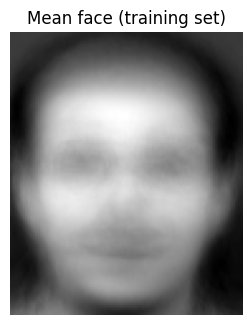

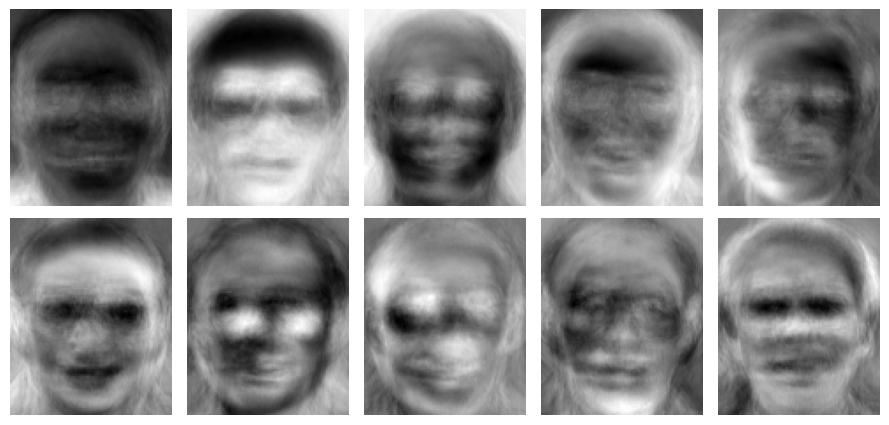

In [5]:
# Mean face (original pixel scale from training set)
mean_face = X_train.mean(axis=0)
plt.figure(figsize=(3,4))
plt.imshow(mean_face.reshape((img_h,img_w)), cmap='gray')
plt.title('Mean face (training set)')
plt.axis('off')
plt.show()

# Visualize first 10 Eigenfaces (from standardized covariance eigenvectors)
k_show = 10
evecs10, _ = top_k_components(k_show)
eigenface_images = []
for i in range(k_show):
    img = evecs10[:, i]  # shape (n_pixels,)
    img = (img - img.min()) / (img.max()-img.min()) * 255.0
    eigenface_images.append(img)
show_images(eigenface_images, h=img_h, w=img_w, ncols=5)

## 5) Image reconstruction with different numbers of principal components

We'll project some sample test images into PCA space for different k, reconstruct them and display the results side-by-side to compare reconstruction quality.

Originals:


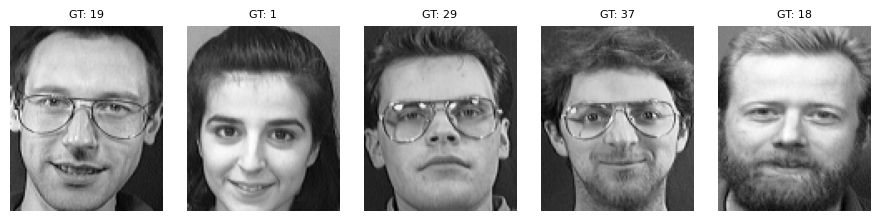

Reconstructions with k=5


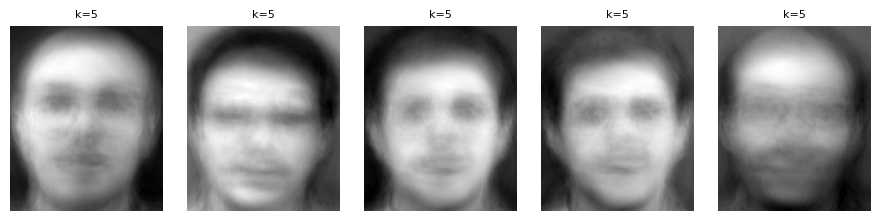

Reconstructions with k=20


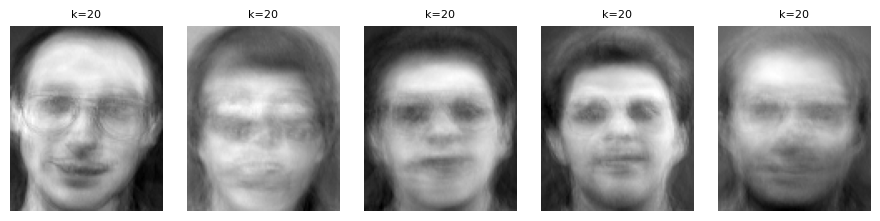

Reconstructions with k=50


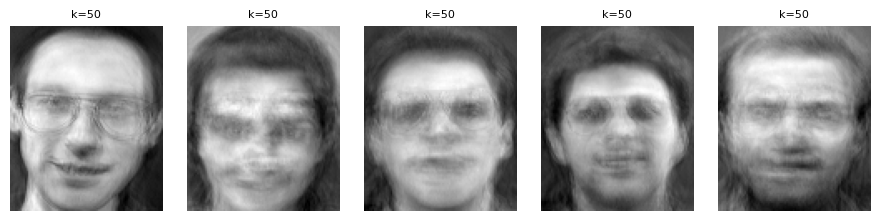

Reconstructions with k=100


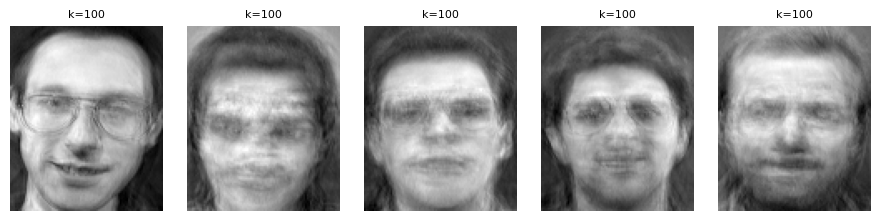

Reconstructions with k=200


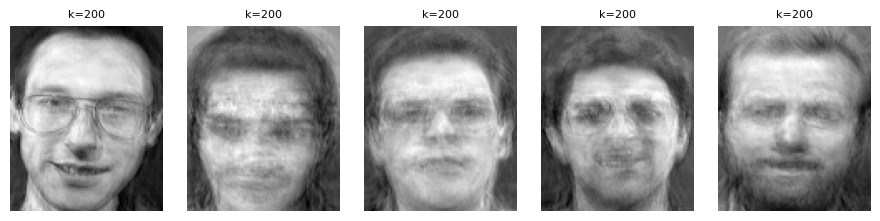

In [6]:
def reconstruct(X_std, evecs_k, scaler):
    # X_std: standardized data (n_samples, n_features)
    # evecs_k: (n_features, k)
    # project and reconstruct in standardized space then inverse-transform to original pixel scale
    weights = X_std.dot(evecs_k)  # (n_samples, k)
    X_rec_std = weights.dot(evecs_k.T)  # (n_samples, n_features)
    X_rec = scaler.inverse_transform(X_rec_std)  # back to original pixel scale
    return X_rec

# pick 5 random test samples to show reconstructions
rng = np.random.default_rng(1)
sample_idxs = rng.choice(len(X_test), size=5, replace=False)
originals = X_test[sample_idxs]
original_titles = [f'GT: {y_test[i]}' for i in sample_idxs]

ks = [5, 20, 50, 100, 200]  # different component counts to compare
recon_sets = []
for k in ks:
    evecs_k, _ = top_k_components(k)
    Xrec = reconstruct(X_test_std[sample_idxs], evecs_k, scaler)
    recon_sets.append(Xrec)

# display originals then each reconstruction row-by-row
print('Originals:')
show_images(originals, titles=original_titles, h=img_h, w=img_w)
for i, k in enumerate(ks):
    print(f'Reconstructions with k={k}')
    show_images(recon_sets[i], titles=[f'k={k}' for _ in range(len(sample_idxs))], h=img_h, w=img_w)

## 6) Face recognition using 1-NN in PCA space

We'll implement a simple 1-nearest-neighbor classifier in PCA space (Euclidean distance). We'll evaluate accuracy on the test set for different numbers of principal components k.

k=  1  acc=0.142
k=  6  acc=0.900
k= 11  acc=0.908
k= 16  acc=0.942
k= 21  acc=0.933
k= 26  acc=0.933
k= 31  acc=0.942
k= 36  acc=0.950
k= 41  acc=0.950
k= 46  acc=0.950
k= 51  acc=0.950
k= 56  acc=0.933
k= 61  acc=0.942
k= 66  acc=0.950
k= 71  acc=0.933
k= 76  acc=0.925
k= 81  acc=0.925
k= 86  acc=0.925
k= 91  acc=0.933
k= 96  acc=0.933
k=101  acc=0.933
k= 66  acc=0.950
k= 71  acc=0.933
k= 76  acc=0.925
k= 81  acc=0.925
k= 86  acc=0.925
k= 91  acc=0.933
k= 96  acc=0.933
k=101  acc=0.933
k=106  acc=0.933
k=111  acc=0.925
k=116  acc=0.925
k=121  acc=0.925
k=126  acc=0.925
k=106  acc=0.933
k=111  acc=0.925
k=116  acc=0.925
k=121  acc=0.925
k=126  acc=0.925
k=131  acc=0.925
k=136  acc=0.917
k=141  acc=0.917
k=146  acc=0.917
k=131  acc=0.925
k=136  acc=0.917
k=141  acc=0.917
k=146  acc=0.917


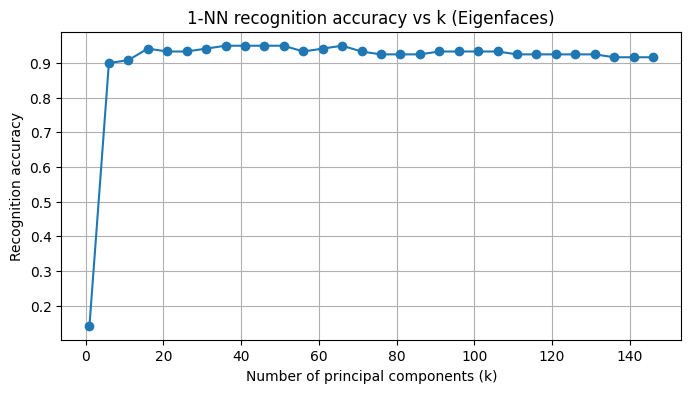

In [7]:
def knn_predict_1nn(X_train_proj, y_train, x_test_proj):
    x = np.atleast_2d(x_test_proj)
    # compute pairwise distances between x and X_train_proj
    dists = np.linalg.norm(x[:, None, :] - X_train_proj[None, :, :], axis=2)  # (n_tests, n_train)
    idx = np.argmin(dists, axis=1)
    return y_train[idx]

# Evaluate accuracy for a range of k values
k_values = list(range(1, 151, 5))
k_values = [k for k in k_values if k <= X_train.shape[1]]
accuracies = []
for k in k_values:
    evecs_k, _ = top_k_components(k)
    Xtr_proj = X_train_std.dot(evecs_k)
    Xte_proj = X_test_std.dot(evecs_k)
    y_pred = knn_predict_1nn(Xtr_proj, y_train, Xte_proj)
    acc = (y_pred == y_test).mean()
    accuracies.append(acc)
    print(f'k={k:3d}  acc={acc:.3f}')

# Plot accuracy vs k
plt.figure(figsize=(8,4))
plt.plot(k_values, accuracies, marker='o')
plt.xlabel('Number of principal components (k)')
plt.ylabel('Recognition accuracy')
plt.title('1-NN recognition accuracy vs k (Eigenfaces)')
plt.grid(True)
plt.show()

## 7) Performance analysis and discussion

The plot above shows recognition accuracy as a function of the number of principal components k. Generally, accuracy increases with more components up to a point then plateaus. Lower k may discard discriminative features; very large k may include noise and overfit. Consider computing per-subject confusion or inspecting misclassified images for deeper analysis.

## 8) Bonus: t-SNE on PCA features (visualization)

We'll use the top-50 PCA components to get compact features, then apply t-SNE to reduce to 2D for visualization. This helps see clustering by subject. t-SNE is computationally heavier; we use a random subset for speed.

Running t-SNE on 300 samples (this may take ~30-90s depending on CPU)


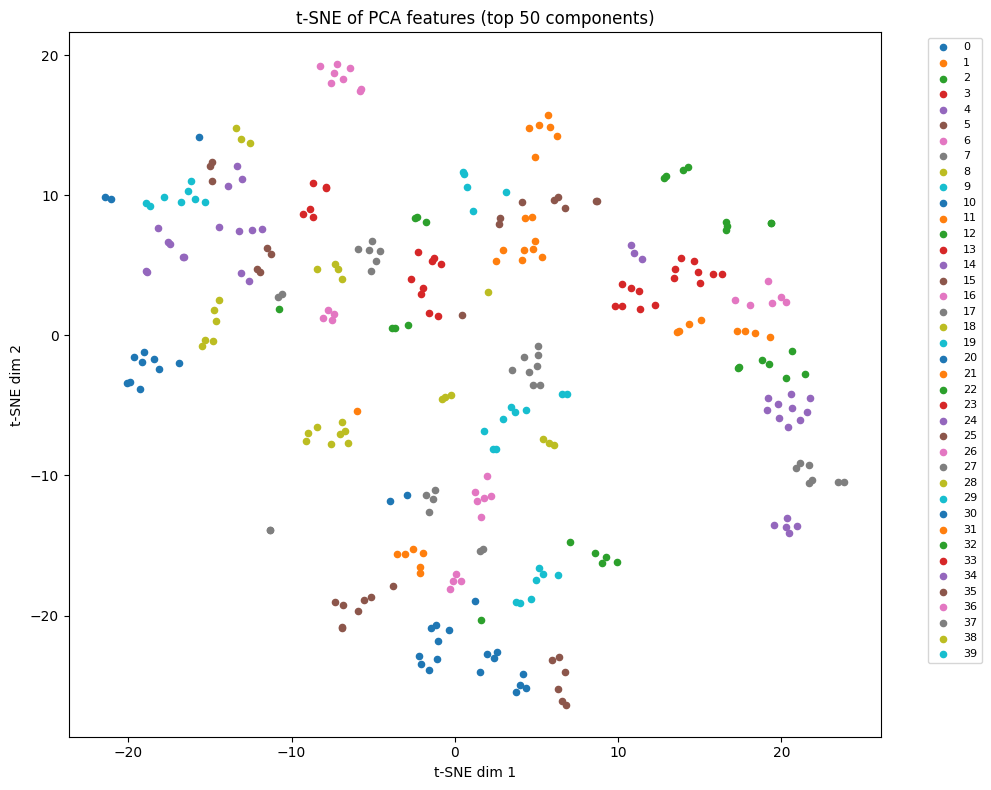

In [11]:
# Choose number of PCA components to feed into t-SNE
k_tsne = 50
evecs_k, _ = top_k_components(k_tsne)
X_proj_all = np.vstack([X_train_std, X_test_std])  # standardized full set
y_all = np.hstack([y_train, y_test])
X_feat = X_proj_all.dot(evecs_k)  # (400, k_tsne)

# Optionally subsample for faster t-SNE visualization
n_samples_tsne = 300
idxs = np.arange(X_feat.shape[0])
rng = np.random.default_rng(0)
sel = rng.choice(idxs, size=n_samples_tsne, replace=False) if X_feat.shape[0] > n_samples_tsne else idxs
X_tsne_in = X_feat[sel]
y_tsne = y_all[sel]

print('Running t-SNE on', X_tsne_in.shape[0], 'samples (this may take ~30-90s depending on CPU)')
tsne = TSNE(n_components=2, perplexity=30, max_iter=1000, random_state=42, init='pca')
Z = tsne.fit_transform(X_tsne_in)

# scatter plot colored by subject label (up to 40 classes)
plt.figure(figsize=(10,8))
for cl in np.unique(y_tsne):
    mask = (y_tsne == cl)
    plt.scatter(Z[mask,0], Z[mask,1], s=20, label=str(cl))
plt.legend(bbox_to_anchor=(1.05,1), loc='upper left', ncol=1, fontsize=8)
plt.title('t-SNE of PCA features (top %d components)' % k_tsne)
plt.xlabel('t-SNE dim 1')
plt.ylabel('t-SNE dim 2')
plt.tight_layout()
plt.show()

## Notes, reproducibility and next steps

- PCA is implemented from scratch using covariance and eigen-decomposition as requested.
- Standardization is applied (zero mean, unit variance) using training statistics. Reconstructions are inverse-transformed back to original pixel scale.
- Classification used a simple 1-NN (Euclidean) in PCA space. You can swap this for k-NN, SVM, or LDA for improvements.
- For speed and numerical stability on large images, using SVD-based PCA (or sklearn.decomposition.PCA) is recommended in production.

Next steps you can try: vary the train/test split, try different classifiers, compute per-subject confusion matrices, and test robustness to occlusion or noise.